In [80]:
import json
import pandas as pd
from nltk.tokenize import word_tokenize

In [81]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download("punkt_tab")

from nltk import pos_tag
nltk.download("averaged_perceptron_tagger_eng")

from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zhuangxiaojian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/zhuangxiaojian/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/zhuangxiaojian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuangxiaojian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
data = []

for file_number in range(1, 37):
    with open(f'outputs/json/{file_number}.json', 'r', encoding='utf-8') as f:
        file_data = json.load(f)
        data.append(file_data)


In [96]:
tf = pd.DataFrame(data)

In [19]:
wob_analysis = [
    "responsibilities",
    "required_core_skills",
    "desirable_skills"
]


In [21]:
distribution_analysis = [
    "level",
    "employment_type",
    "programming_languages",
    "frameworks_tools",
    "databases",
    "cloud_platforms",
    "api_protocols",
    "methodologies",
    "mobile_technologies",
    "work_permit_required",
    "visa_sponsorship",
    

]

In [22]:
tokenized_analysis = [
    "location",
    "role",
    "education_required",
    "language_requirements",
    "domain_keywords"
    
]

In [23]:
numbers_data = [
    "years_experience_min",
    "years_experience_max",
    "salary_eur_min",
    "salary_eur_max",
]

#### TFIDF 

In [ ]:
from collections import defaultdict
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_skills(data):
    match_data = defaultdict(lambda: {
        "programming_languages": [],
        "frameworks_tools": [],
        "cloud_platforms": [],
        "databases":[],
        "api_protocols":[],
        "methodologies": []
    })

    for _, row in data.iterrows():
        r = row["role"]
        if pd.isna(r):
            continue
        match_data[r]["programming_languages"].extend(row["programming_languages"])
        match_data[r]["frameworks_tools"].extend(row["frameworks_tools"])
        match_data[r]["cloud_platforms"].extend(row["cloud_platforms"])
        match_data[r]["databases"].extend(row["databases"])
        match_data[r]["api_protocols"].extend(row["api_protocols"])
        match_data[r]["methodologies"].extend(row["methodologies"])

    role_docs = {}

    for role, fields in match_data.items():
        all_skills = []
        for skill_list in fields.values():
            all_skills.extend(skill_list)
        skill_text = " ".join(all_skills)  # 词袋字符串
        role_docs[role] = skill_text

    roles = list(role_docs.keys())
    docs = list(role_docs.values())

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(docs)  # shape: (num_roles, num_skills)

    feature_names = vectorizer.get_feature_names_out()

    top_k = 10
    role_top_skills = {}

    for i, role in enumerate(roles):
        row = X[i].toarray()[0]  # index i's TF-IDF vector
        top_indices = np.argsort(row)[::-1][:top_k]
        top_skills = [(feature_names[j], row[j]) for j in top_indices if row[j] > 0]
        role_top_skills[role] = top_skills

    return role_top_skills

PMI

In [ ]:
from collections import Counter
from itertools import combinations
import math
import networkx as nx


def get_PMI_networks():
    job_skills_list = []
    for _, row in tf.iterrows():
        skills = []
        skills.extend(row["programming_languages"])
        skills.extend(row["frameworks_tools"])
        skills.extend(row["cloud_platforms"])
        skills.extend(row["databases"])
        skills.extend(row["api_protocols"])
        skills.extend(row["methodologies"])
        job_skills_list.append(skills)

        skill_freq = Counter()
        pair_freq = Counter()
        total_docs = len(job_skills_list)

        for skill_list in job_skills_list:
            skills = set(skill_list)  # 去重，只考虑“是否出现”
            for s in skills:
                skill_freq[s] += 1
            for s1, s2 in combinations(sorted(skills), 2):  # 排序 + 两两组合
                pair_freq[(s1, s2)] += 1

            pmi_scores = {}

            for (s1, s2), co_freq in pair_freq.items():
                p_x = skill_freq[s1] / total_docs
                p_y = skill_freq[s2] / total_docs
                p_xy = co_freq / total_docs

                if p_xy > 0 and p_x > 0 and p_y > 0:
                    pmi = math.log2(p_xy / (p_x * p_y))
                    pmi_scores[(s1, s2)] = pmi

        MIN_COFREQ = 3
        pmi_filtered = {
            (s1, s2): pmi
            for (s1, s2), pmi in pmi_scores.items()
            if pair_freq[(s1, s2)] >= MIN_COFREQ and pmi > 0
        }
        G = nx.Graph()

        for (s1, s2), pmi in pmi_filtered.items():
            G.add_edge(s1, s2, weight=pmi)


In [ ]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, k=0.5)
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue", edge_color="gray")
plt.title("Skill Co-occurrence Network (PMI Weighted)")
plt.show()




In [ ]:
LEVEL_SCORE = {
    "intern": 1,
    "junior": 2,
    "mid": 3,
    "senior": 4,
    "lead": 5,
    "manager": 6,
}

In [64]:
import spacy
nlp = spacy.load("en_core_web_sm")


In [91]:
tf['responsibilities']

0     [assist_in_testing,_debugging,_and_deploying_n...
1     [analyze_applications_to_identify_vulnerabilit...
2     [maintain_a_proactive_and_positive_attitude_in...
3     [assist_in_analyzing_and_addressing_complex_pr...
4     [experience_in_monitoring_tools_such_as_autosy...
5     [build_software_from_the_ground_up_and_take_fu...
6     [accessing_asic_registers_over_spi_bus,_smbus,...
7     [collaborate_with_development_on_intelligent_a...
8     [developing_skills_and_awareness_of_security_i...
9     [coding_solutions,_completing_unit_tests,_and_...
10    [assistance_in_developing_and_integrating_inte...
11    [collaborate_with_cross_functional_teams_to_in...
12    [design,_develop,_and_implement_data_driven_so...
13                                                   []
14    [assist_in_developing_and_implementing_server_...
15    [conduct_code_reviews_of_other_team_members_wo...
16    [learning_days_–_take_time_to_focus_on_your_fi...
17    [assist_in_the_configuration_and_customiza

In [98]:
import nltk
from typing import List
from nltk import word_tokenize, pos_tag

def count_action_verbs(responsibilities: List[str]) -> int:
    text = " ".join(r.replace("_", " ") for r in responsibilities)
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "VERB")

def compute_odi_tools(row):
    skills = (
        row["programming_languages"]
        + row["frameworks_tools"]
        + row["cloud_platforms"]
        + row["databases"]
        + row["api_protocols"]
        + row["methodologies"]
    )
    num_skills = len(set(skills))
    num_verbs = count_action_verbs(row["responsibilities"])
    if num_verbs == 0:
        return None
    return round(num_skills / num_verbs, 2)


In [102]:
tf["ODI_tools"] = tf.apply(compute_odi_tools, axis=1)
tf["is_haio_jd"] = tf["ODI_tools"].apply(lambda x: x > 1.0 if pd.notna(x) else False)


In [104]:
print("总 JD 数：", len(tf))
print("有效 ODI 数：", tf["ODI_tools"].notna().sum())
print("海王 JD 数量：", tf["is_haio_jd"].sum())
print("海王占比：{:.2%}".format(tf["is_haio_jd"].mean()))
print("ODI 均值（全部）：", round(tf["ODI_tools"].mean(), 2))
print("ODI 均值（海王）：", round(tf[tf["is_haio_jd"]]["ODI_tools"].mean(), 2))

总 JD 数： 36
有效 ODI 数： 32
海王 JD 数量： 4
海王占比：11.11%
ODI 均值（全部）： 0.62
ODI 均值（海王）： 1.51


/var/folders/kg/sv7mcxxx3gs6hd98075nl0p40000gn/T/ipykernel_75624/2611233331.py:15: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kg/sv7mcxxx3gs6hd98075nl0p40000gn/T/ipykernel_75624/2611233331.py:15: UserWarning: Glyph 24037 (\N{CJK UNIFIED IDEOGRAPH-5DE5}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kg/sv7mcxxx3gs6hd98075nl0p40000gn/T/ipykernel_75624/2611233331.py:15: UserWarning: Glyph 20855 (\N{CJK UNIFIED IDEOGRAPH-5177}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kg/sv7mcxxx3gs6hd98075nl0p40000gn/T/ipykernel_75624/2611233331.py:15: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kg/sv7mcxxx3gs6hd98075nl0p40000gn/T/ipykernel_75624/2611233331.py:15: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kg/sv7mcxxx3gs6hd98075nl0p40000gn/T/i

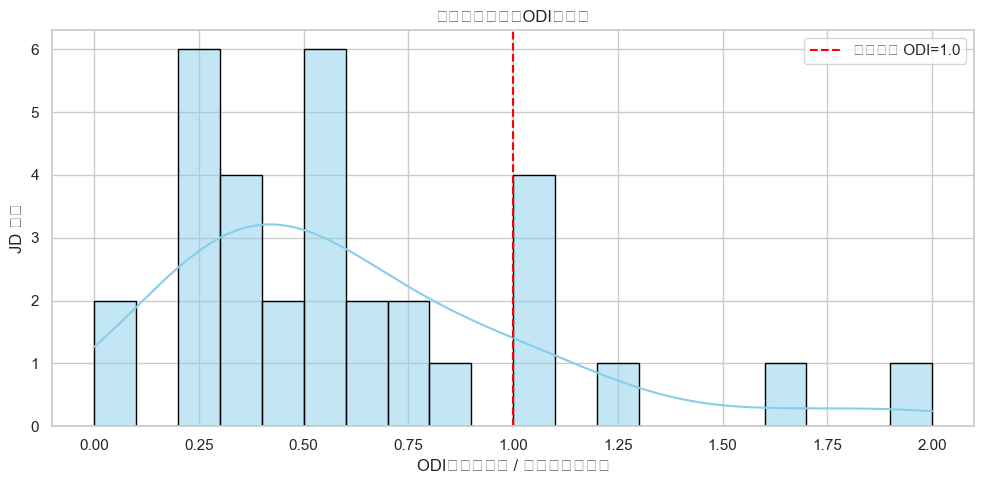

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置风格
sns.set(style="whitegrid")

# 画 ODI 分布图
plt.figure(figsize=(10, 5))
sns.histplot(tf["ODI_tools"].dropna(), bins=20, kde=True, color="skyblue", edgecolor="black")
plt.axvline(1.0, color="red", linestyle="--", label="海王阈值 ODI=1.0")
plt.title("工具密度指标（ODI）分布")
plt.xlabel("ODI（工具数量 / 职责动词数量）")
plt.ylabel("JD 数量")
plt.legend()
plt.tight_layout()
plt.show()
